# Stock Market Prediction using Numerical and Textual Analysis

By Anubhav Sarkar

**Objective:**
1. Create a hybrid model for stock price/performance prediction using numerical analysis of historical stock prices, and sentimental analysis of news headlines.
2. Stock to analyze and predict - SENSEX (S&P BSE SENSEX)

### Importing Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

import math
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Dense, Activation

import nltk
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *

from sklearn import preprocessing, metrics
from sklearn.preprocessing import MinMaxScaler

### Obtaining Data from yahoo.finance

#### Historical data of S&P BSE SENSEX

In [2]:
from pandas_datareader import data as pdr
import yfinance as yf

yf.pdr_override()

stock_price = pdr.get_data_yahoo("%5EBSESN", start = '2001-01-01', end = '2021-09-01')

[*********************100%***********************]  1 of 1 completed


In [3]:
stock_price.head(10)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2001-01-02,3953.219971,4028.570068,3929.370117,4018.879883,4018.879883,0
2001-01-03,3977.580078,4067.659912,3977.580078,4060.020020,4060.020020,0
2001-01-04,4180.970215,4180.970215,4109.549805,4115.370117,4115.370117,0
2001-01-05,4116.339844,4195.009766,4115.350098,4183.729980,4183.729980,0
2001-01-08,4164.759766,4206.720215,4101.529785,4120.430176,4120.430176,0
2001-01-09,4114.740234,4166.839844,4101.009766,4125.310059,4125.310059,0
2001-01-10,4151.580078,4155.859863,4035.439941,4047.639893,4047.639893,0
2001-01-11,4066.129883,4077.540039,4006.540039,4027.129883,4027.129883,0
2001-01-12,4059.409912,4082.770020,4018.280029,4036.580078,4036.580078,0


In [4]:
# displaying number of records in both stock_price
len(stock_price)

5084

In [5]:
# checking for null values
stock_price.isna().any()

Open         False
High         False
Low          False
Close        False
Adj Close    False
Volume       False
dtype: bool

In [6]:
# dropping duplicates
stock_price = stock_price.drop_duplicates()

# dropping the zero values from volume
stock_price = stock_price[stock_price['Volume'] != 0]

# filtering the important columns required
stock_price = stock_price.filter(['Date', 'Close', 'Open', 'High', 'Low', 'Volume'])

# sorting the data according to the index i.e 'Date'
stock_price = stock_price.sort_index(ascending=True, axis=0)
stock_price

,Close,Open,High,Low,Volume
Date,,,,,
2003-07-14,3720.750000,3704.629883,3726.560059,3704.629883,21200
2003-07-15,3686.340088,3719.169922,3733.879883,3657.179932,22800
2003-07-16,3721.649902,3702.139893,3729.020020,3662.699951,18400
2003-07-17,3668.909912,3728.840088,3750.000000,3660.340088,22000
2003-07-18,3647.580078,3651.389893,3684.229980,3625.729980,22000
...,...,...,...,...,...
2021-08-25,55944.210938,56067.058594,56198.128906,55899.960938,5400
2021-08-26,55949.101562,55988.410156,56112.390625,55854.070312,8300
2021-08-27,56124.718750,55862.929688,56188.230469,55675.871094,6000


### Stock Headlines

In [7]:
# displaying stock news headlines dataset
stock_headlines = pd.read_csv('india-news-headlines.csv')
stock_headlines.head()

,publish_date,headline_category,headline_text
0,20010102,unknown,Status quo will not be disturbed at Ayodhya; s...
1,20010102,unknown,Fissures in Hurriyat over Pak visit
2,20010102,unknown,America's unwanted heading for India?
3,20010102,unknown,For bigwigs; it is destination Goa
4,20010102,unknown,Extra buses to clear tourist traffic


In [8]:
# displaying number of records in both stock_headlines
len(stock_headlines)

3424067

In [9]:
# checking for null values
stock_headlines.isna().any()

publish_date         False
headline_category    False
headline_text        False
dtype: bool

In [10]:
# dropping duplicates
stock_headlines = stock_headlines.drop_duplicates()

# coverting the datatype of column 'Date' from type string to type 'datetime'
stock_headlines['publish_date'] = stock_headlines['publish_date'].astype(str)
stock_headlines['publish_date'] = stock_headlines['publish_date'].apply(lambda x: x[0:4]+'-'+x[4:6]+'-'+x[6:8])
stock_headlines['publish_date'] = pd.to_datetime(stock_headlines['publish_date']).dt.normalize()

# filtering the important columns required
stock_headlines = stock_headlines.filter(['publish_date', 'headline_text'])

# grouping the news headlines according to 'Date'
stock_headlines = stock_headlines.groupby(['publish_date'])['headline_text'].apply(lambda x: ','.join(x)).reset_index()

# setting column 'Date' as the index column
stock_headlines.set_index('publish_date', inplace= True)

# sorting the data according to the index i.e 'Date'
stock_headlines = stock_headlines.sort_index(ascending=True, axis=0)
stock_headlines

,headline_text
publish_date,
2001-01-02,Status quo will not be disturbed at Ayodhya; s...
2001-01-03,"Powerless north India gropes in the dark,Think..."
2001-01-04,The string that pulled Stephen Hawking to Indi...
2001-01-05,Light combat craft takes India into club class...
2001-01-06,Light combat craft takes India into club class...
...,...
2020-12-27,#BigInterview! Dhritiman Chatterjee: Nobody da...
2020-12-28,Horoscope Today; 28 December 2020: Check astro...
2020-12-29,Man recovers charred remains of 'thief' from h...


### Combined Stock Data

In [11]:
# concatenating the datasets stock_price and stock_headlines
stock_data = pd.concat([stock_price, stock_headlines], axis=1)

# dropping the null values if any
stock_data.dropna(axis=0, inplace=True)

# displaying the combined stock_data
stock_data

,Close,Open,High,Low,Volume,headline_text
2003-07-14,3720.750000,3704.629883,3726.560059,3704.629883,21200.0,"Hot enough or fast enough?,Fat can be addictiv..."
2003-07-15,3686.340088,3719.169922,3733.879883,3657.179932,22800.0,"New boat building yard to be set up in Kochi,N..."
2003-07-16,3721.649902,3702.139893,3729.020020,3662.699951,18400.0,"MD's fake diploma finally gets him,India to se..."
2003-07-17,3668.909912,3728.840088,3750.000000,3660.340088,22000.0,"Indians are unwilling to swipe their cards,Sou..."
2003-07-18,3647.580078,3651.389893,3684.229980,3625.729980,22000.0,Airtel receives Govt nod for additional spectr...
...,...,...,...,...,...,...
2020-12-24,46973.539062,46743.488281,47053.398438,46539.019531,13700.0,How to set the mood for sex during cold winter...
2020-12-28,47353.750000,47153.589844,47406.718750,47148.238281,9600.0,Horoscope Today; 28 December 2020: Check astro...
2020-12-29,47613.078125,47466.621094,47714.550781,47361.898438,12800.0,Man recovers charred remains of 'thief' from h...
2020-12-30,47746.218750,47789.031250,47807.851562,47358.359375,15600.0,Numerology Readings 30 December 2020: Predicti...


### Calculating Sentiment Scores

In [12]:
# adding empty sentiment columns to stock_data for later calculation
stock_data['compound'] = ''
stock_data['negative'] = ''
stock_data['neutral'] = ''
stock_data['positive'] = ''
stock_data.head()

,Close,Open,High,Low,Volume,headline_text,compound,negative,neutral,positive
2003-07-14,3720.750000,3704.629883,3726.560059,3704.629883,21200.0,"Hot enough or fast enough?,Fat can be addictiv...",,,,
2003-07-15,3686.340088,3719.169922,3733.879883,3657.179932,22800.0,"New boat building yard to be set up in Kochi,N...",,,,
2003-07-16,3721.649902,3702.139893,3729.020020,3662.699951,18400.0,"MD's fake diploma finally gets him,India to se...",,,,
2003-07-17,3668.909912,3728.840088,3750.000000,3660.340088,22000.0,"Indians are unwilling to swipe their cards,Sou...",,,,
2003-07-18,3647.580078,3651.389893,3684.229980,3625.729980,22000.0,Airtel receives Govt nod for additional spectr...,,,,


In [13]:
# importing requires libraries to analyze the sentiments
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import unicodedata

# instantiating the Sentiment Analyzer
sid = SentimentIntensityAnalyzer()

# calculating sentiment scores
stock_data['compound'] = stock_data['headline_text'].apply(lambda x: sid.polarity_scores(x)['compound'])
stock_data['negative'] = stock_data['headline_text'].apply(lambda x: sid.polarity_scores(x)['neg'])
stock_data['neutral'] = stock_data['headline_text'].apply(lambda x: sid.polarity_scores(x)['neu'])
stock_data['positive'] = stock_data['headline_text'].apply(lambda x: sid.polarity_scores(x)['pos'])

# displaying the stock data
stock_data.head()

,Close,Open,High,Low,Volume,headline_text,compound,negative,neutral,positive
2003-07-14,3720.750000,3704.629883,3726.560059,3704.629883,21200.0,"Hot enough or fast enough?,Fat can be addictiv...",-0.9983,0.128,0.822,0.050
2003-07-15,3686.340088,3719.169922,3733.879883,3657.179932,22800.0,"New boat building yard to be set up in Kochi,N...",-0.6484,0.096,0.814,0.090
2003-07-16,3721.649902,3702.139893,3729.020020,3662.699951,18400.0,"MD's fake diploma finally gets him,India to se...",-0.9973,0.127,0.801,0.071
2003-07-17,3668.909912,3728.840088,3750.000000,3660.340088,22000.0,"Indians are unwilling to swipe their cards,Sou...",-0.9991,0.138,0.810,0.052
2003-07-18,3647.580078,3651.389893,3684.229980,3625.729980,22000.0,Airtel receives Govt nod for additional spectr...,0.8516,0.075,0.834,0.090


### Finalising Stock Data and writing to Disk

In [14]:
# dropping the 'headline_text' which is unwanted now
stock_data.drop(['headline_text'], inplace=True, axis=1)

# rearranging the columns of the whole stock_data
stock_data = stock_data[['Close', 'compound', 'negative', 'neutral', 'positive', 'Open', 'High', 'Low', 'Volume']]

# displaying the final stock_data
stock_data.head(10)

,Close,compound,negative,neutral,positive,Open,High,Low,Volume
2003-07-14,3720.750000,-0.9983,0.128,0.822,0.050,3704.629883,3726.560059,3704.629883,21200.0
2003-07-15,3686.340088,-0.6484,0.096,0.814,0.090,3719.169922,3733.879883,3657.179932,22800.0
2003-07-16,3721.649902,-0.9973,0.127,0.801,0.071,3702.139893,3729.020020,3662.699951,18400.0
2003-07-17,3668.909912,-0.9991,0.138,0.810,0.052,3728.840088,3750.000000,3660.340088,22000.0
2003-07-18,3647.580078,0.8516,0.075,0.834,0.090,3651.389893,3684.229980,3625.729980,22000.0
2003-07-21,3569.580078,-0.5972,0.084,0.829,0.087,3655.260010,3664.639893,3564.409912,19400.0
2003-07-22,3554.129883,-0.9987,0.143,0.796,0.061,3557.129883,3582.080078,3534.060059,22400.0
2003-07-23,3577.889893,-0.9993,0.154,0.799,0.047,3571.750000,3596.590088,3551.979980,31800.0
2003-07-24,3668.070068,-0.9973,0.131,0.784,0.085,3595.600098,3677.239990,3572.639893,44400.0
2003-07-25,3726.459961,-0.9973,0.117,0.809,0.073,3685.310059,3737.760010,3661.689941,25800.0


In [15]:
# writing the prepared stock_data to disk
stock_data.to_csv('stock_data.csv')

### Rereading the data

In [16]:
# re-reading the stock_data into pandas dataframe
stock_data = pd.read_csv('stock_data.csv', index_col = False)

# renaming the column
stock_data.rename(columns={'Unnamed: 0':'Date'}, inplace = True)

# setting the column 'Date' as the index column
stock_data.set_index('Date', inplace=True)

# displaying the stock_data
stock_data.head()

,Close,compound,negative,neutral,positive,Open,High,Low,Volume
Date,,,,,,,,,
2003-07-14,3720.750000,-0.9983,0.128,0.822,0.050,3704.629883,3726.560059,3704.629883,21200.0
2003-07-15,3686.340088,-0.6484,0.096,0.814,0.090,3719.169922,3733.879883,3657.179932,22800.0
2003-07-16,3721.649902,-0.9973,0.127,0.801,0.071,3702.139893,3729.020020,3662.699951,18400.0
2003-07-17,3668.909912,-0.9991,0.138,0.810,0.052,3728.840088,3750.000000,3660.340088,22000.0
2003-07-18,3647.580078,0.8516,0.075,0.834,0.090,3651.389893,3684.229980,3625.729980,22000.0


### Feature Engineering

In [17]:
# displaying the shape i.e. number of rows and columns of stock_data
stock_data.shape

(4294, 9)

In [18]:
# checking for null values
stock_data.isna().any()

Close       False
compound    False
negative    False
neutral     False
positive    False
Open        False
High        False
Low         False
Volume      False
dtype: bool

In [19]:
# displaying stock_data statistics
stock_data.describe(include='all')

,Close,compound,negative,neutral,positive,Open,High,Low,Volume
count,4294.000000,4294.000000,4294.000000,4294.000000,4294.000000,4294.000000,4294.000000,4294.000000,4.294000e+03
mean,20828.705872,-0.892348,0.128414,0.784320,0.087261,20851.486605,20976.136562,20685.740316,9.196782e+04
std,10308.722046,0.421145,0.021568,0.027684,0.016268,10325.864435,10354.244817,10268.446379,1.141723e+06
min,3554.129883,-1.000000,0.038000,0.637000,0.024000,3557.129883,3582.080078,3534.060059,8.000000e+02
25%,13788.067627,-0.999800,0.116000,0.765000,0.077000,13782.347412,13931.057129,13667.879639,1.100000e+04
50%,18762.770508,-0.999400,0.129000,0.781000,0.087000,18763.264648,18884.189453,18655.330078,1.520000e+04
75%,28110.425293,-0.996000,0.142000,0.801000,0.097000,28127.535645,28234.850586,27958.460449,2.200000e+04
max,47751.328125,1.000000,0.216000,0.903000,0.255000,47789.031250,47896.968750,47602.121094,3.181510e+07


In [20]:
# displaying stock_data information
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4294 entries, 2003-07-14 to 2020-12-31
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Close     4294 non-null   float64
 1   compound  4294 non-null   float64
 2   negative  4294 non-null   float64
 3   neutral   4294 non-null   float64
 4   positive  4294 non-null   float64
 5   Open      4294 non-null   float64
 6   High      4294 non-null   float64
 7   Low       4294 non-null   float64
 8   Volume    4294 non-null   float64
dtypes: float64(9)
memory usage: 335.5+ KB


### Exploratory Data Analysis

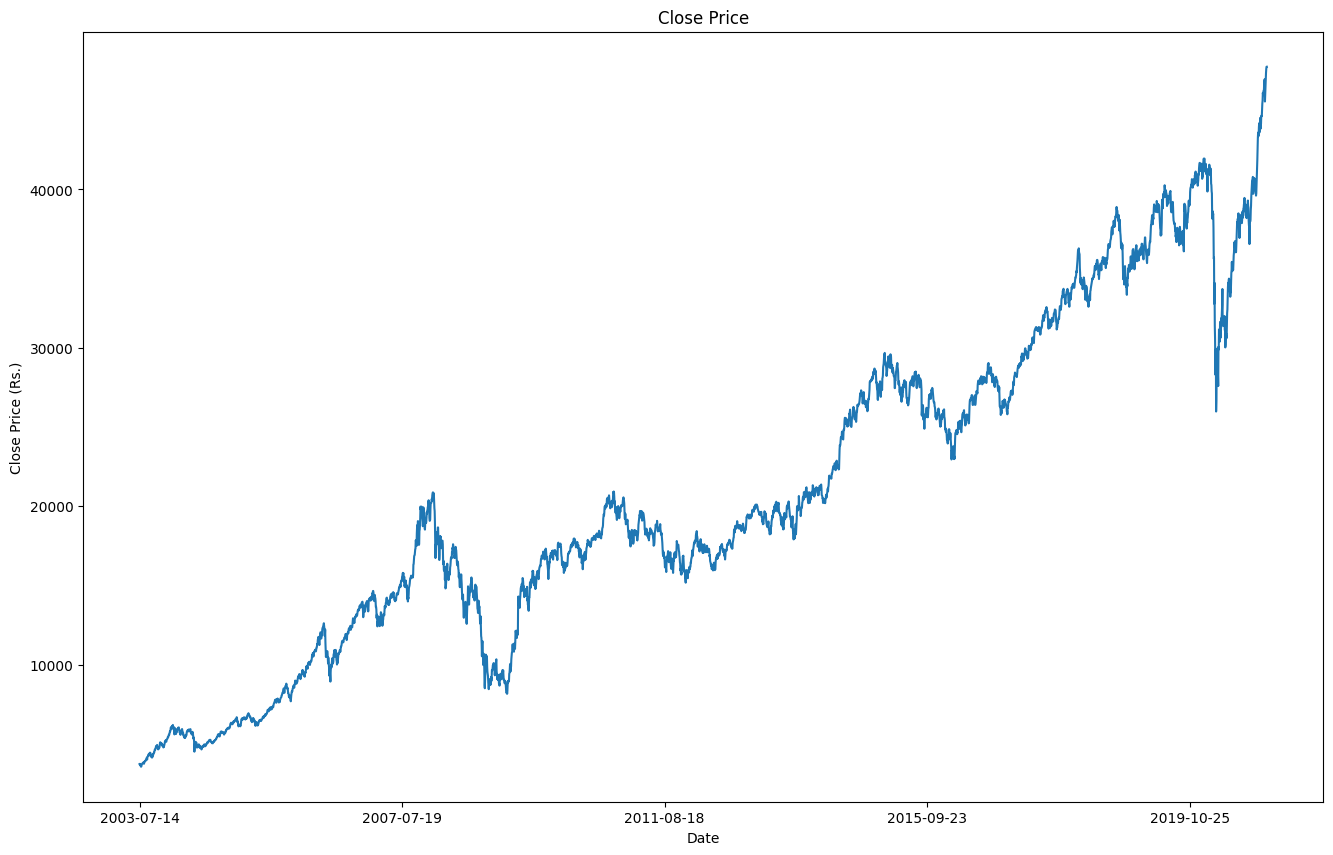

In [21]:
# setting figure size
plt.figure(figsize=(16,10))

# plotting close price
stock_data['Close'].plot()

# setting plot title, x and y labels
plt.title("Close Price")
plt.xlabel('Date')
plt.ylabel('Close Price (Rs.)')
plt.show()

In [22]:
# calculating 7 day rolling mean
stock_data.rolling(7).mean().head(20)

,Close,compound,negative,neutral,positive,Open,High,Low,Volume
Date,,,,,,,,,
2003-07-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2003-07-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2003-07-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2003-07-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2003-07-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2003-07-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2003-07-22,3652.705706,-0.626771,0.113000,0.815143,0.071571,3674.079939,3695.772845,3629.864258,21171.428571
2003-07-23,3632.297119,-0.626914,0.116714,0.811857,0.071143,3655.097098,3677.205706,3608.057129,22685.714286
2003-07-24,3629.687116,-0.676757,0.121714,0.807571,0.070429,3637.444266,3669.114293,3595.979980,25771.428571


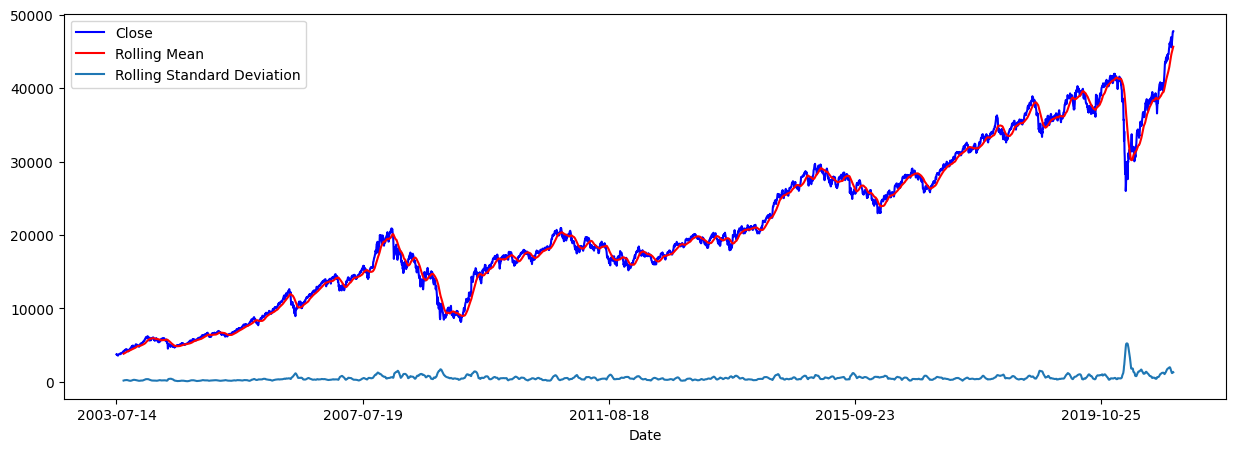

In [23]:
# plotting the close price and a 30-day rolling mean of close price
close = stock_data['Close']
ma = close.rolling(window = 30).mean()
std = close.rolling(window = 30).std()

plt.figure(figsize=(15, 5))
stock_data['Close'].plot(color = 'b', label = 'Close')
ma.plot(color = 'red', label = 'Rolling Mean')
std.plot(label = 'Rolling Standard Deviation')
plt.legend()
plt.show()

In [24]:
# displaying stock_data
stock_data

,Close,compound,negative,neutral,positive,Open,High,Low,Volume
Date,,,,,,,,,
2003-07-14,3720.750000,-0.9983,0.128,0.822,0.050,3704.629883,3726.560059,3704.629883,21200.0
2003-07-15,3686.340088,-0.6484,0.096,0.814,0.090,3719.169922,3733.879883,3657.179932,22800.0
2003-07-16,3721.649902,-0.9973,0.127,0.801,0.071,3702.139893,3729.020020,3662.699951,18400.0
2003-07-17,3668.909912,-0.9991,0.138,0.810,0.052,3728.840088,3750.000000,3660.340088,22000.0
2003-07-18,3647.580078,0.8516,0.075,0.834,0.090,3651.389893,3684.229980,3625.729980,22000.0
...,...,...,...,...,...,...,...,...,...
2020-12-24,46973.539062,-0.9971,0.082,0.854,0.064,46743.488281,47053.398438,46539.019531,13700.0
2020-12-28,47353.750000,-0.9997,0.126,0.789,0.085,47153.589844,47406.718750,47148.238281,9600.0
2020-12-29,47613.078125,-0.9998,0.136,0.774,0.090,47466.621094,47714.550781,47361.898438,12800.0


### Data Preparation for modelling

In [25]:
# calculating data_to_use
percentage_of_data = 1.0
data_to_use = int(percentage_of_data*(len(stock_data)-1))

# using 80% of data for training
train_end = int(data_to_use*0.8)
total_data = len(stock_data)
start = total_data - data_to_use

# printing number of records in the training and test datasets
print("Number of records in Training Data:", train_end)
print("Number of records in Test Data:", total_data - train_end)

Number of records in Training Data: 3434
Number of records in Test Data: 860


In [26]:
# predicting one step ahead
steps_to_predict = 1

# capturing data to be used for each column
close_price = stock_data.iloc[start:total_data,0] #close
compound = stock_data.iloc[start:total_data,1] #compound
negative = stock_data.iloc[start:total_data,2] #neg
neutral = stock_data.iloc[start:total_data,3] #neu
positive = stock_data.iloc[start:total_data,4] #pos
open_price = stock_data.iloc[start:total_data,5] #open
high = stock_data.iloc[start:total_data,6] #high
low = stock_data.iloc[start:total_data,7] #low
volume = stock_data.iloc[start:total_data,8] #volume

In [27]:
# printing close price
print("Close Price:")
close_price

Close Price:


Date
2003-07-15     3686.340088
2003-07-16     3721.649902
2003-07-17     3668.909912
2003-07-18     3647.580078
2003-07-21     3569.580078
                  ...     
2020-12-24    46973.539062
2020-12-28    47353.750000
2020-12-29    47613.078125
2020-12-30    47746.218750
2020-12-31    47751.328125
Name: Close, Length: 4293, dtype: float64

In [28]:
# shifting next day close
close_price_shifted = close_price.shift(-1) 

# shifting next day compound
compound_shifted = compound.shift(-1) 

# concatenating the captured training data into a dataframe
data = pd.concat([close_price, close_price_shifted, compound, compound_shifted, volume, open_price, high, low], axis=1)

# setting column names of the revised stock data
data.columns = ['close_price', 'close_price_shifted', 'compound', 'compound_shifted','volume', 'open_price', 'high', 'low']

# dropping nulls
data = data.dropna()    
data.head(10)

,close_price,close_price_shifted,compound,compound_shifted,volume,open_price,high,low
Date,,,,,,,,
2003-07-15,3686.340088,3721.649902,-0.6484,-0.9973,22800.0,3719.169922,3733.879883,3657.179932
2003-07-16,3721.649902,3668.909912,-0.9973,-0.9991,18400.0,3702.139893,3729.020020,3662.699951
2003-07-17,3668.909912,3647.580078,-0.9991,0.8516,22000.0,3728.840088,3750.000000,3660.340088
2003-07-18,3647.580078,3569.580078,0.8516,-0.5972,22000.0,3651.389893,3684.229980,3625.729980
2003-07-21,3569.580078,3554.129883,-0.5972,-0.9987,19400.0,3655.260010,3664.639893,3564.409912
2003-07-22,3554.129883,3577.889893,-0.9987,-0.9993,22400.0,3557.129883,3582.080078,3534.060059
2003-07-23,3577.889893,3668.070068,-0.9993,-0.9973,31800.0,3571.750000,3596.590088,3551.979980
2003-07-24,3668.070068,3726.459961,-0.9973,-0.9973,44400.0,3595.600098,3677.239990,3572.639893
2003-07-25,3726.459961,3739.760010,-0.9973,-0.9987,25800.0,3685.310059,3737.760010,3661.689941


### Setting the Target Variable and the Feature Dataset

In [29]:
# setting the target variable as the shifted close_price
y = data['close_price_shifted']
y

Date
2003-07-15     3721.649902
2003-07-16     3668.909912
2003-07-17     3647.580078
2003-07-18     3569.580078
2003-07-21     3554.129883
                  ...     
2020-12-23    46973.539062
2020-12-24    47353.750000
2020-12-28    47613.078125
2020-12-29    47746.218750
2020-12-30    47751.328125
Name: close_price_shifted, Length: 4292, dtype: float64

In [30]:
# setting the features dataset for prediction  
cols = ['close_price', 'compound', 'compound_shifted', 'volume', 'open_price', 'high', 'low']
x = data[cols]
x

,close_price,compound,compound_shifted,volume,open_price,high,low
Date,,,,,,,
2003-07-15,3686.340088,-0.6484,-0.9973,22800.0,3719.169922,3733.879883,3657.179932
2003-07-16,3721.649902,-0.9973,-0.9991,18400.0,3702.139893,3729.020020,3662.699951
2003-07-17,3668.909912,-0.9991,0.8516,22000.0,3728.840088,3750.000000,3660.340088
2003-07-18,3647.580078,0.8516,-0.5972,22000.0,3651.389893,3684.229980,3625.729980
2003-07-21,3569.580078,-0.5972,-0.9987,19400.0,3655.260010,3664.639893,3564.409912
...,...,...,...,...,...,...,...
2020-12-23,46444.179688,-0.9996,-0.9971,10500.0,46072.300781,46513.320312,45899.101562
2020-12-24,46973.539062,-0.9971,-0.9997,13700.0,46743.488281,47053.398438,46539.019531
2020-12-28,47353.750000,-0.9997,-0.9998,9600.0,47153.589844,47406.718750,47148.238281


### Scaling the Target Variable and the Feature Dataset

In [31]:
# scaling the feature dataset
scaler_x = preprocessing.MinMaxScaler (feature_range=(-1, 1))
x = np.array(x).reshape((len(x) ,len(cols)))
x = scaler_x.fit_transform(x)

# scaling the target variable
scaler_y = preprocessing.MinMaxScaler (feature_range=(-1, 1))
y = np.array (y).reshape ((len( y), 1))
y = scaler_y.fit_transform (y)

# displaying the scaled feature dataset and the target variable
x, y

(array([[-0.99401657, -0.6484    , -0.9973    , ..., -0.99267316,
         -0.99313523, -0.99438166],
        [-0.99241855, -0.9973    , -0.9991    , ..., -0.99344319,
         -0.99335501, -0.99412976],
        [-0.9948054 , -0.9991    ,  0.8516    , ..., -0.99223591,
         -0.99240624, -0.99423745],
        ...,
        [ 0.98223805, -0.9997    , -0.9998    , ...,  0.97126773,
          0.98185977,  0.99025003],
        [ 0.99397446, -0.9998    , -0.9998    , ...,  0.98542183,
          0.99578071,  1.        ],
        [ 1.        , -0.9998    , -0.9996    , ...,  1.        ,
          1.        ,  0.9998385 ]]),
 array([[-0.99241943],
        [-0.994806  ],
        [-0.99577122],
        ...,
        [ 0.99374395],
        [ 0.99976879],
        [ 1.        ]]))

### Dividing the dataset into Training and Test

In [32]:
# preparing training and test dataset
X_train = x[0 : train_end,]
X_test = x[train_end+1 : len(x),]    
y_train = y[0 : train_end] 
y_test = y[train_end+1 : len(y)]  

# printing the shape of the training and the test datasets
print('Number of rows and columns in the Training set X:', X_train.shape, 'and y:', y_train.shape)
print('Number of rows and columns in the Test set X:', X_test.shape, 'and y:', y_test.shape)

Number of rows and columns in the Training set X: (3434, 7) and y: (3434, 1)
Number of rows and columns in the Test set X: (857, 7) and y: (857, 1)


### Reshaping the Feature Dataset

In [33]:
# reshaping the feature dataset for feeding into the model
X_train = X_train.reshape (X_train.shape + (1,)) 
X_test = X_test.reshape(X_test.shape + (1,))

# printing the re-shaped feature dataset
print('Shape of Training set X:', X_train.shape)
print('Shape of Test set X:', X_test.shape)

Shape of Training set X: (3434, 7, 1)
Shape of Test set X: (857, 7, 1)


### Data Modelling

In [34]:
# setting the seed to achieve consistent and less random predictions at each execution
np.random.seed(2016)

# setting the model architecture
model=Sequential()
model.add(LSTM(100,return_sequences=True,activation='tanh',input_shape=(len(cols),1)))
model.add(Dropout(0.1))
model.add(LSTM(100,return_sequences=True,activation='tanh'))
model.add(Dropout(0.1))
model.add(LSTM(100,activation='tanh'))
model.add(Dropout(0.1))
model.add(Dense(1))

# printing the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 7, 100)            40800     
_________________________________________________________________
dropout (Dropout)            (None, 7, 100)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 7, 100)            80400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 100)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1

In [35]:
# compiling the model
model.compile(loss='mse' , optimizer='adam')

# fitting the model using the training dataset
model.fit(X_train, y_train, validation_split=0.2, epochs=10, batch_size=8, verbose=1)

Epoch 1/10
344/344 [==============================] - 23s 34ms/step - loss: 0.0613 - val_loss: 0.0225
Epoch 2/10
344/344 [==============================] - 8s 22ms/step - loss: 0.0028 - val_loss: 0.0037
Epoch 3/10
344/344 [==============================] - 7s 21ms/step - loss: 0.0013 - val_loss: 1.9358e-04
Epoch 4/10
344/344 [==============================] - 8s 22ms/step - loss: 0.0014 - val_loss: 9.4398e-04- loss: 0.001
Epoch 5/10
344/344 [==============================] - 7s 21ms/step - loss: 0.0013 - val_loss: 6.6177e-04
Epoch 6/10
344/344 [==============================] - 8s 23ms/step - loss: 0.0011 - val_loss: 3.6416e-04
Epoch 7/10
344/344 [==============================] - 7s 22ms/step - loss: 0.0011 - val_loss: 2.0473e-04
Epoch 8/10
344/344 [==============================] - 8s 22ms/step - loss: 0.0011 - val_loss: 2.6679e-04
Epoch 9/10
344/344 [==============================] - 7s 22ms/step - loss: 8.9729e-04 - val_loss: 1.7200e-04
Epoch 10/10
344/344 [========================

### Saving the Model to disk

In [36]:
# saving the model as a json file
model_json = model.to_json()
with open('model.json', 'w') as json_file:
    json_file.write(model_json)
    
# serialize weights to HDF5
model.save_weights('model.h5')

### Predictions

In [37]:
# performing predictions
predictions = model.predict(X_test) 

# unscaling the predictions
predictions = scaler_y.inverse_transform(np.array(predictions).reshape((len(predictions), 1)))

# printing the predictions
print('Predictions:')
predictions

Predictions:


array([[31532.162],
       [31544.625],
       [31787.145],
       [31991.447],
       [31994.385],
       [32165.908],
       [32225.887],
       [32273.426],
       [31966.002],
       [32080.926],
       [32168.23 ],
       [32156.037],
       [32370.697],
       [32504.94 ],
       [32508.234],
       [32714.629],
       [32675.818],
       [32472.225],
       [32763.965],
       [32776.863],
       [32594.275],
       [32422.95 ],
       [32533.156],
       [32392.207],
       [32063.879],
       [31822.434],
       [31463.12 ],
       [31751.662],
       [31618.658],
       [32043.63 ],
       [31779.627],
       [31666.85 ],
       [31556.535],
       [31654.99 ],
       [31815.578],
       [31946.35 ],
       [31785.83 ],
       [31796.676],
       [31853.854],
       [31998.557],
       [31984.129],
       [31958.186],
       [31860.656],
       [31914.701],
       [31873.082],
       [32044.523],
       [32253.047],
       [32428.014],
       [32467.086],
       [32440.355],


### Evaluation

In [38]:
# calculating the training mean-squared-error
train_loss = model.evaluate(X_train, y_train, batch_size = 1)

# calculating the test mean-squared-error
test_loss = model.evaluate(X_test, y_test, batch_size = 1)

# printing the training and the test mean-squared-errors
print('Train Loss =', round(train_loss,4))
print('Test Loss =', round(test_loss,4))

857/857 [==============================] - 5s 5ms/step - loss: 0.0010
Train Loss = 0.0004
Test Loss = 0.001


In [39]:
# calculating root mean squared error
root_mean_square_error = np.sqrt(np.mean(np.power((y_test - predictions),2)))
print('Root Mean Square Error =', round(root_mean_square_error,4))

Root Mean Square Error = 37129.558


In [40]:
# calculating root mean squared error using sklearn.metrics package
rmse = metrics.mean_squared_error(y_test, predictions)
print('Root Mean Square Error (sklearn.metrics) =', round(np.sqrt(rmse),4))

Root Mean Square Error (sklearn.metrics) = 37129.558


### Plotting the Predictions against unseen data

In [41]:
# unscaling the test feature dataset, x_test
X_test = scaler_x.inverse_transform(np.array(X_test).reshape((len(X_test), len(cols))))

# unscaling the test y dataset, y_test
y_train = scaler_y.inverse_transform(np.array(y_train).reshape((len(y_train), 1)))
y_test = scaler_y.inverse_transform(np.array(y_test).reshape((len(y_test), 1)))

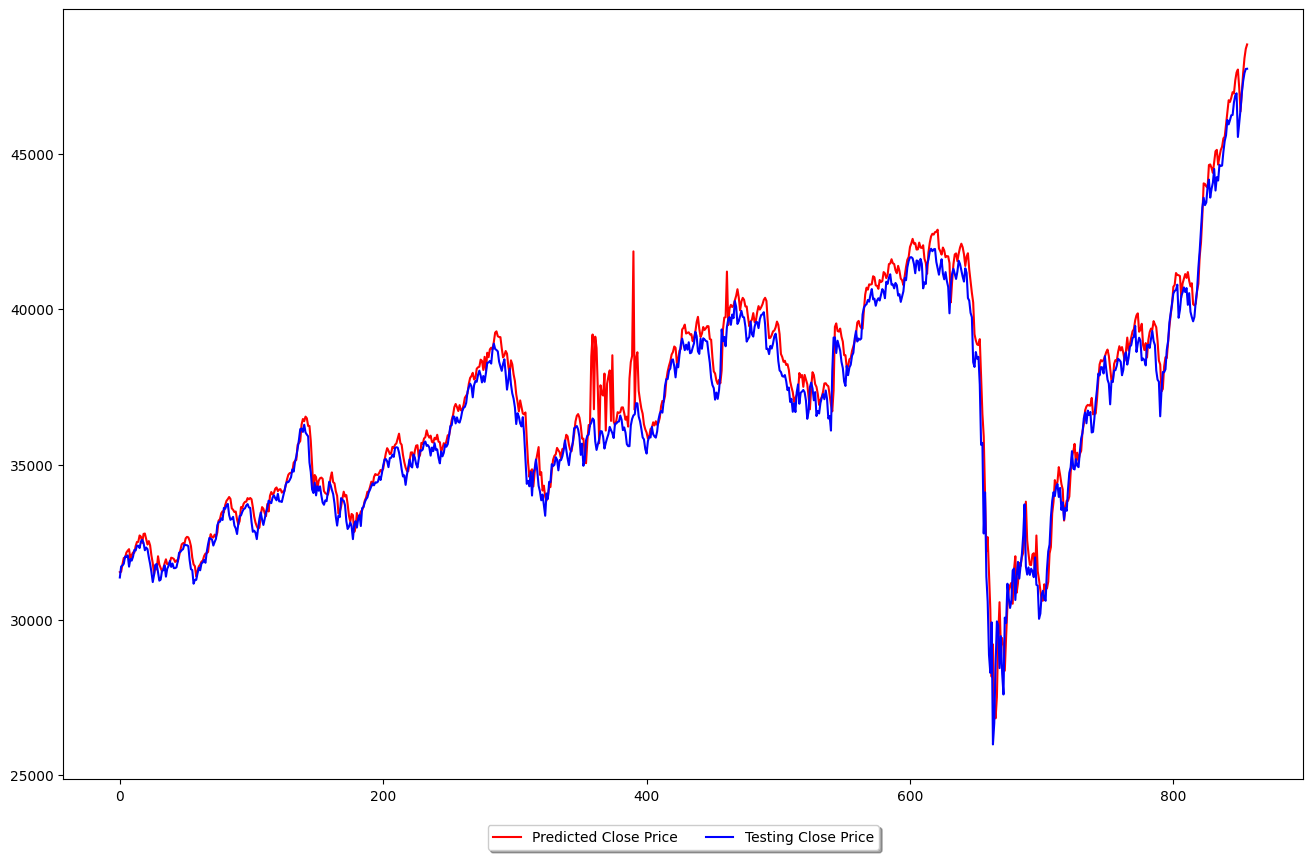

In [55]:
# plotting
plt.figure(figsize=(16,10))

# plt.plot([row[0] for row in y_train], label="Training Close Price")
plt.plot(predictions,color = 'r', label="Predicted Close Price")
plt.plot([row[0] for row in y_test],color = 'b', label="Testing Close Price")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=2)
plt.show()


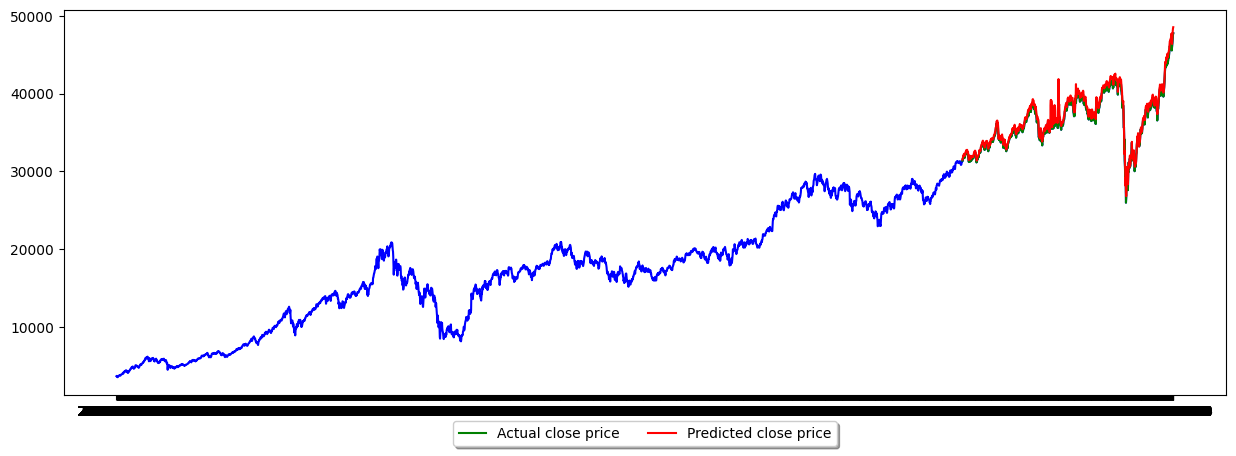

In [64]:
val = data[len(y_train)+1:]
val['pred'] = predictions
plt.figure(figsize = (15,5))
plt.plot(data['close_price'], color = 'b')
plt.plot(val['close_price'], label = 'Actual close price', color = 'g')
plt.plot(val['pred'], label = 'Predicted close price', color = 'r')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=2)
plt.show()